<h1><center>Data Augmentation using GANs </center></h1>

In this notebook we will introduce the Pix2Pix and CycleGAN training process on data created from carla simulator. In this repository you will find a smaller dataset for demonstration purposes. A larger dataset can be find on <a href="https://www.kaggle.com/datasets/buraka61/carla-simulator-weather-data-default-to-rainy">Kaggle.com</a>.

In [2]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
import os
import time
import warnings
warnings.filterwarnings("ignore")
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import BatchNormalization
from PIL import Image
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from IPython.display import display
from tensorflow.keras.utils import plot_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [1]:
print("Hello World")

Hello World


In [3]:
os.getcwd()

'C:\\Users\\burak.altin\\AppData\\Local\\Programs\\Microsoft VS Code'

Loaded:  (60, 256, 256, 3) (60, 256, 256, 3)


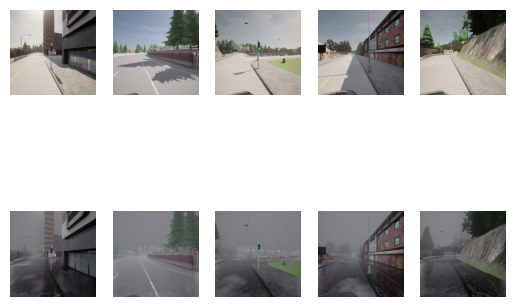

In [4]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the face dataset
data = load("cyclegan_ds.npz")
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [3]:
class define():
    class discriminator:
      def patchgan(image_shape):   
          # weight initialization
            init = RandomNormal(stddev=0.02)
            # source image input
            in_src_image = Input(shape=image_shape)
            # target image input
            ### patchgan will take the binary loss
            in_target_image = Input(shape=image_shape)
            # concatenate images channel-wise
            merged = Concatenate()([in_src_image, in_target_image])
            # C64
            d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
            d = LeakyReLU(alpha=0.2)(d)
            # C128
            d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # C256
            d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # C512
            d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # second last output layer
            d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
            d = BatchNormalization()(d)
            d = LeakyReLU(alpha=0.2)(d)
            # patch output
            d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
            patch_out = Activation('sigmoid')(d)
            # define model
            model = Model([in_src_image, in_target_image], patch_out)
            # compile model
            opt = Adam(learning_rate=0.0002, beta_1=0.5)
            model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
            return model
      
      def cnn(image_shape):
          # weight initialization
            init = RandomNormal(stddev=0.02)
            # source image input
            in_image = Input(shape=image_shape)
            ##cnn will take the mse
            # C64
            d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
            d = LeakyReLU(alpha=0.2)(d)
            # C128
            d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # C256
            d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # C512
            d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # second last output layer
            d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
            d = InstanceNormalization(axis=-1)(d)
            d = LeakyReLU(alpha=0.2)(d)
            # patch output
            patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
            # define model
            model = Model(in_image, patch_out)
            # compile model
            model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
            return model
    
    class generator:
      def __define_encoder_block__(layer_in, n_filters, batchnorm=True):
          # weight initialization
          init = RandomNormal(stddev=0.02)
          # add downsampling layer
          g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same',
          kernel_initializer=init)(layer_in)
          # conditionally add batch normalization
          if batchnorm:
              g = BatchNormalization()(g, training=True)
          # leaky relu activation
          g = LeakyReLU(alpha=0.2)(g)
          return g
      def __decoder_block__(layer_in, skip_in, n_filters, dropout=True):
          # weight initialization
          init = RandomNormal(stddev=0.02)
          # add upsampling layer
          g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same',
          kernel_initializer=init)(layer_in)
          # add batch normalization
          g = BatchNormalization()(g, training=True)
          # conditionally add dropout
          if dropout:
              g = Dropout(0.5)(g, training=True)
          # merge with skip connection
          g = Concatenate()([g, skip_in])
          # relu activation
          g = Activation('relu')(g)
          return g
      def _resnet_block(n_filters, input_layer):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # first layer convolutional layer
        g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # second convolutional layer
        g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        # concatenate merge channel-wise with input layer
        g = Concatenate()([g, input_layer])
        return g
      
      def u_net(image_shape):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # encoder model
        e1 = define.generator.__define_encoder_block__(in_image, 64, batchnorm=False)
        e2 = define.generator.__define_encoder_block__(e1, 128)
        e3 = define.generator.__define_encoder_block__(e2, 256)
        e4 = define.generator.__define_encoder_block__(e3, 512)
        e5 = define.generator.__define_encoder_block__(e4, 512)
        e6 = define.generator.__define_encoder_block__(e5, 512)
        e7 = define.generator.__define_encoder_block__(e6, 512)
        # bottleneck, no batch norm and relu
        b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
        b = Activation('relu')(b)
        # decoder model
        d1 = define.generator.__decoder_block__(b, e7, 512)
        d2 = define.generator.__decoder_block__(d1, e6, 512)
        d3 = define.generator.__decoder_block__(d2, e5, 512)
        d4 = define.generator.__decoder_block__(d3, e4, 512, dropout=False)
        d5 = define.generator.__decoder_block__(d4, e3, 256, dropout=False)
        d6 = define.generator.__decoder_block__(d5, e2, 128, dropout=False)
        d7 = define.generator.__decoder_block__(d6, e1, 64, dropout=False)
        # output
        g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
        out_image = Activation('tanh')(g)
        # define model
        model = Model(in_image, out_image)
        return model
      def res_net(image_shape, n_resnet=9):
          # weight initialization
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # c7s1-64
        g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # d128
        g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # d256
        g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # R256
        for _ in range(n_resnet):
          g = define.generator._resnet_block(256, g)
        # u128
        g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # u64
        g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        g = Activation('relu')(g)
        # c7s1-3
        g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
        g = InstanceNormalization(axis=-1)(g)
        out_image = Activation('tanh')(g)
        # define model
        model = Model(in_image, out_image)
        return model
    class composite_model:
       def cycle_gan(g_model_1, d_model, g_model_2, image_shape):
        g_model_1.trainable = True
        d_model.trainable = False
        g_model_2.trainable = False
        input_gen = Input(shape=image_shape)
        gen1_out = g_model_1(input_gen)
        output_d = d_model(gen1_out)
        input_id = Input(shape = image_shape)
        output_id = g_model_1(input_id)
        output_f = g_model_2(gen1_out)
        gen2_out = g_model_2(input_id)
        output_b = g_model_1(gen2_out)
        model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
        return model
       def pix2pix(g_model, d_model, image_shape):
        # make weights in the discriminator not trainable,
        # since Batchnormalization must not be "learned"
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = False
        # define the source image
        in_src = Input(shape=image_shape)
        # connect the source image to the generator input
        gen_out = g_model(in_src)
        # connect the source input and generator output to the discriminator input
        dis_out = d_model([in_src, gen_out])
        # src image as input, generated image and classification output
        model = Model(in_src, [dis_out, gen_out])
        # compile model
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
        return model
          

            
     

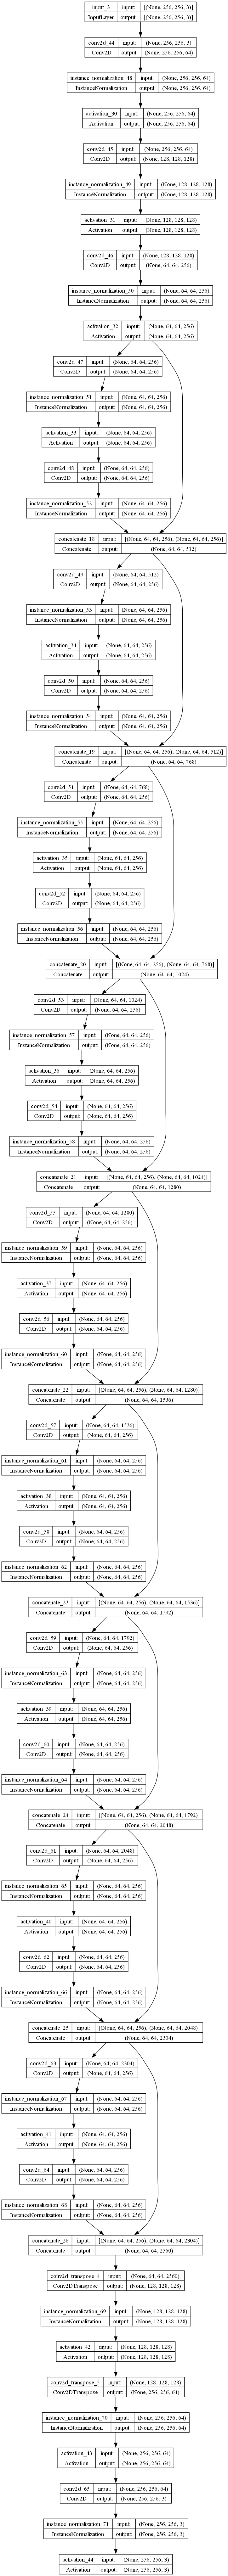

In [7]:
dataset = load_dataset('cyclegan_ds.npz')
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
model = define.generator.res_net(image_shape=image_shape)
plot_model(model, show_shapes=True, show_layer_names=True,show_layer_activations=False)

In [7]:
class generate_pictures():
    class real():
        def cycle_gan(dataset, n_samples, patch_shape):
            #choose random pictures inside the dataset
            ix = randint(0, dataset.shape[0], n_samples)
            X = dataset[ix]
            y = ones((n_samples, patch_shape, patch_shape, 1))
            return X, y
        def pix2pix(dataset, n_samples, patch_shape):
            # unpack dataset
            trainA, trainB = dataset
            # choose random instances
            ix = randint(0, trainA.shape[0], n_samples)
            # retrieve selected images
            X1, X2 = trainA[ix], trainB[ix]
            # generate 'real' class labels (1)
            y = ones((n_samples, patch_shape, patch_shape, 1))
            return [X1, X2], y
    class fake():
        ###both methods do the same, but the user would be irritated if there are just one option
        def cycle_gan(g_model, dataset, patch_shape):
            # generate fake instance
            X = g_model.predict(dataset)
            # create 'fake' class labels (0)
            y = zeros((len(X), patch_shape, patch_shape, 1))
            return X, y
        def pix2pix(g_model, samples, patch_shape):
            # generate fake instance
            X = g_model.predict(samples)
            # create 'fake' class labels (0)
            y = zeros((len(X), patch_shape, patch_shape, 1))
            return X, y
    



In [8]:
class performance():
    def cycle_gan(step, g_model, trainX, name, n_samples=5):
        # select a sample of input images
        X_in, _ = generate_pictures.real.cycle_gan(trainX, n_samples, 0)
        # generate translated images
        X_out, _ = generate_pictures.fake.cycle_gan(g_model, X_in, 0)
        # scale all pixels from [-1,1] to [0,1]
        X_in = (X_in + 1) / 2.0
        X_out = (X_out + 1) / 2.0
        # plot real images
        for i in range(n_samples):
            plt.subplot(2, n_samples, 1 + i)
            plt.axis('off')
            plt.imshow(X_in[i])
        # plot translated image
        for i in range(n_samples):
            plt.subplot(2, n_samples, 1 + n_samples + i)
            plt.axis('off')
            plt.imshow(X_out[i])
        plt.figtext(0.05, 0.95, "%d. Epoche" % step, fontsize=12, ha='left')
        return plt
        
        # save plot to file
	
    def pix2pix(step, g_model, dataset, n_samples=5):
        [X_realA, X_realB], _ = generate_pictures.real.pix2pix(dataset, n_samples, 1)
        # generate a batch of fake samples
        X_fakeB, _ = generate_pictures.fake.pix2pix(g_model, X_realA, 1)
        # scale all pixels from [-1,1] to [0,1]
        X_realA = (X_realA + 1) / 2.0
        X_realB = (X_realB + 1) / 2.0
        X_fakeB = (X_fakeB + 1) / 2.0
        # plot real source images
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + i)
            plt.axis('off')
            plt.imshow(X_realA[i])
        # plot generated target image
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + n_samples + i)
            plt.axis('off')
            plt.imshow(X_fakeB[i])
        # plot real target image
        for i in range(n_samples):
            plt.subplot(3, n_samples, 1 + n_samples*2 + i)
            plt.axis('off')
            plt.imshow(X_realB[i])
        plt.figtext(0.05, 0.95, "%d. Epoche" % step, fontsize=12, ha='left')
        return plt
        

In [10]:
class train_gan():
    def __update_image_pool__(pool, images, max_size=50):
        selected = list()
        for image in images:
            if len(pool) < max_size:
                # stock the pool
                pool.append(image)
                selected.append(image)
            elif random() < 0.5:
                # use image, but don't add it to the pool
                selected.append(image)
            else:
                # replace an existing image and use replaced image
                ix = randint(0, len(pool))
                selected.append(pool[ix])
                pool[ix] = image
        return asarray(selected)
    def pix2pix(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
        # determine the output square shape of the discriminator
        n_patch = d_model.output_shape[1]
        # calculate the number of batches per training epoch
        bat_per_epo = int(len(dataset[0]) / n_batch)
        # calculate the number of training iterations
        n_steps = bat_per_epo * n_epochs
        # manually enumerate epochs
        for i in range(n_steps):
            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_pictures.real.pix2pix(dataset, n_batch, n_patch)
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_pictures.fake.pix2pix(g_model, X_realA, n_patch)
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            # summarize model performance
            plt = performance.pix2pix(i, g_model, dataset)
            clear_output(wait=True)
            plt.show()
    def cycle_gan(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
        # define properties of the training run
        n_epochs, n_batch, = 100, 1
        # determine the output square shape of the discriminator
        n_patch = d_model_A.output_shape[1]
        # unpack dataset
        trainA, trainB = dataset
        # prepare image pool for fakes
        poolA, poolB = list(), list()
        # calculate the number of batches per training epoch
        bat_per_epo = int(len(trainA) / n_batch)
        # calculate the number of training iterations
        n_steps = bat_per_epo * n_epochs
        # manually enumerate epochs
        for i in range(n_steps):
            # select a batch of real samples
            X_realA, y_realA = generate_pictures.real.cycle_gan(trainA, n_batch, n_patch)
            X_realB, y_realB = generate_pictures.real.cycle_gan(trainB, n_batch, n_patch)
            # generate a batch of fake samples
            X_fakeA, y_fakeA = generate_pictures.fake.cycle_gan(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_pictures.fake.cycle_gan(g_model_AtoB, X_realA, n_patch)
            # update fakes from pool
            X_fakeA = train_gan.__update_image_pool__(poolA, X_fakeA)
            X_fakeB = train_gan.__update_image_pool__(poolB, X_fakeB)
            # update generator B->A via adversarial and cycle loss
            g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
            # update discriminator for A -> [real/fake]
            dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            # update generator A->B via adversarial and cycle loss
            g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            # update discriminator for B -> [real/fake]
            dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            # summarize performance
            #print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
            # evaluate the model performance every so often
            plt = performance.cycle_gan(i, g_model_AtoB, trainA, 'AtoB')
            clear_output(wait=True)
            plt.show()

In [1]:
def load_dataset(filename):
    # load the compressed arrays
    data = load(filename)
    # unpack the arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [ ]:
#### training pix2pix

dataset = load_dataset('pix2pix_ds.npz')
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define.discriminator.patchgan(image_shape)
g_model = define.generator.u_net(image_shape)
# define the composite model
gan_model = define.composite_model.pix2pix(g_model, d_model, image_shape)
# train model
train_gan.pix2pix(d_model, g_model, gan_model,dataset=dataset)


In [ ]:
#### training cyclegan
dataset = load_dataset('cyclegan_ds.npz')
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
###Anzahl der ResNet-Blöcke als Hyperparamater
g_model_AtoB = define.generator.res_net(image_shape, n_resnet=9)

# generator: B -> A
g_model_BtoA = define.generator.res_net(image_shape, n_resnet=9)
# discriminator: A -> [real/fake]
d_model_A = define.discriminator.cnn(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define.discriminator.cnn(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define.composite_model.cycle_gan(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define.composite_model.cycle_gan(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train_gan.cycle_gan(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)